In [1]:
from pymongo import MongoClient
from collections import Counter
import pickle
from bson.son import SON
import operator
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
with open('heavy_metal_parsed.pkl', 'r') as infile:
    heavy_metal_reviews = pickle.load(infile)

In [3]:
client = MongoClient()

In [4]:
hmm = client.dsbc.hmm

In [5]:
hmm.insert(heavy_metal_reviews[0])

ObjectId('555e365d215ae946e59ddbc2')

In [6]:
for review in heavy_metal_reviews[1:]:
    hmm.save(review)

### Challenge 1

Number of metal movies over the years: 856


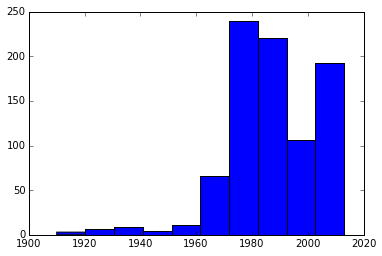

In [7]:
cursor = hmm.find({},{'year':True, '_id':False})
movie_years = [i['year'] for i in cursor]
plt.hist(movie_years)
print 'Number of metal movies over the years: {0}'.format(len(movie_years))

### Challenge 2

In [8]:
cursor = hmm.find({},{'cast':True, '_id':False})

cast_members = []
for i in cursor:
    for j in i['cast']:
        cast_members.append(j)
cnt = Counter()
for member in cast_members:
    cnt[member] += 1

del cnt['']
print max(cnt.iteritems(), key=operator.itemgetter(1))[0]

Alice Cooper


### Challenge 3

In [9]:
cursor = hmm.find({},{'title':True, '_id':False})

title_words = []
for i in cursor:
    title_split = i['title'].split(' ')
    for word in title_split:
        title_words.append(word)
        
title_cnt = Counter()
stop = ['the', 'and','or', 'a', 'of', 'by']
for title_word in title_words:
    # use NLTK corpus stopwords or create on stop words
    if title_word.lower() not in stop:    
        title_cnt[title_word] += 1
print Counter(title_cnt).most_common(10)

[(u'METAL', 29), (u'IN', 25), (u'DEAD', 23), (u'HEAVY', 18), (u'ROCK', 17), (u'TO', 17), (u'BLOOD', 14), (u'BLACK', 14), (u'LAST', 13), (u'DEATH', 12)]


### Challenge 4

In [11]:
pipeline_70s = [
        {"$match": {"year": {"$gt":1970, "$lt":1980}}},
        {"$unwind": "$metal_cred"},
        {"$group": {"_id": "$metal_cred", "count": {"$sum": 1}}},
        {"$sort": SON([("count", -1), ("_id", -1)])}
        ]
        
pipeline_80s = [
        {"$match": {"year": {"$gt":1980, "$lt":1990}}},
        {"$unwind": "$metal_cred"},
        {"$group": {"_id": "$metal_cred", "count": {"$sum": 1}}},
        {"$sort": SON([("count", -1), ("_id", -1)])}
        ]
        
pipeline_90s = [
        {"$match": {"year": {"$gt":1990, "$lt":2000}}},
        {"$unwind": "$metal_cred"},
        {"$group": {"_id": "$metal_cred", "count": {"$sum": 1}}},
        {"$sort": SON([("count", -1), ("_id", -1)])}
        ]
        
pipeline_00s = [
        {"$match": {"year": {"$gt":2000, "$lt":2010}}},
        {"$unwind": "$metal_cred"},
        {"$group": {"_id": "$metal_cred", "count": {"$sum": 1}}},
        {"$sort": SON([("count", -1), ("_id", -1)])}
        ]
        
results_70s = list(hmm.aggregate(pipeline_70s))
results_80s = list(hmm.aggregate(pipeline_80s))
results_90s = list(hmm.aggregate(pipeline_90s))
results_00s = list(hmm.aggregate(pipeline_00s))

words_70s = []
words_80s = []
words_90s = []
words_00s = []

for decade in [results_70s, results_80s, results_90s, results_00s]:
    for el in decade:
        split_words = el['_id'].split(' ')
        for word in split_words:
            for num in range(el['count']):
                if decade == results_70s:
                    if word.lower() not in stop:
                        words_70s.append(word)
                elif decade == results_80s:
                    if word.lower() not in stop:
                        words_80s.append(word)
                elif decade == results_90s:
                    if word.lower() not in stop:
                        words_90s.append(word)
                elif decade == results_00s:
                    if word.lower() not in stop:
                        words_00s.append(word)

cnt_70s = Counter(words_70s)
cnt_80s = Counter(words_80s)
cnt_90s = Counter(words_90s)
cnt_00s = Counter(words_00s)

print 'Top 5 words in 1970s are {0}'.format(Counter(cnt_70s).most_common(5))
print 'Top 5 words in 1980s are {0}'.format(Counter(cnt_80s).most_common(5))
print 'Top 5 words in 1990s are {0}'.format(Counter(cnt_90s).most_common(5))
print 'Top 5 words in 2000s are {0}'.format(Counter(cnt_00s).most_common(5))

Top 5 words in 1970s are [(u'METAL', 144), (u'CRED', 141), (u'\u201970s', 19), (u'Satan', 18), (u'\u201cThe', 11)]
Top 5 words in 1980s are [(u'METAL', 253), (u'CRED', 247), (u'\u201980s', 64), (u'\u2013', 35), (u'Post-Apocalypse', 30)]
Top 5 words in 1990s are [(u'METAL', 89), (u'CRED', 87), (u'Soundtrack:', 34), (u'Black', 8), (u'Satan', 7)]
Top 5 words in 2000s are [(u'METAL', 144), (u'CRED', 141), (u'Soundtrack:', 38), (u'Black', 12), (u'Porn', 12)]


### Challenge 5